## Preparation -- Load Model & Init Explainer

In [1]:
import numpy as np
import torch, torchvision
from torchvision import transforms
from torch import nn
import os, argparse

from gefa import gefa
from gefa import utils
from gefa.utils import log

from tqdm import tqdm
from test import img_eval

import pickle
from matplotlib import pyplot as plt
from matplotlib.colors import TwoSlopeNorm

utils.LOG_LEVEL = 1
torch.hub.set_dir(os.path.join(os.getcwd(), 'models')) 

/srv/public/.local/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
config_pth = './configs/img_config.yaml'
config = utils.load_config(config_pth)

# parser = argparse.ArgumentParser()
ns = argparse.Namespace()
ns.__dict__.update(config)
args = ns

randomly_init = False 
log(ns)

utils.set_seed(args.seed)
log(f'============ Set seed to [{args.seed}] ============')
m_name = args.m_name.lower()

# Load dataset
IMG_SIZE = img_eval.IMG_SIZE_DICT[m_name]
PIX_STATS = img_eval.PIX_STATS_DICT['imagenet']

preprocessing = transforms.Compose([
    transforms.Resize(IMG_SIZE[1:]),
    transforms.ToTensor(),
    transforms.Normalize(*PIX_STATS)
    ])

dataset = torchvision.datasets.ImageFolder('/srv/public/workspace/datasets/IMAGENET/val', preprocessing)
sampler = img_eval.ImageNetSampler_OnePerClass(dataset)
data_loader = torch.utils.data.DataLoader(dataset, sampler=sampler, batch_size=1, shuffle=False)

weights = None if randomly_init else img_eval.M_WEIGHTS_DICT[m_name]
m = img_eval.M_NAME_DICT[m_name](weights=weights)

def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)  # or any other init you prefer
        # nn.init.uniform_(m.weight)  # or any other init you prefer
        if m.bias is not None:
            nn.init.constant_(m.bias, np.random.randn())

# Apply to the whole model
if randomly_init:
    m.apply(init_weights)

m.cuda(), m.eval()
if args.softmax_wrapped:
    m = img_eval.SoftmaxWrapping(m) 
    m.cuda(), m.eval()
log(f'Image size: [{IMG_SIZE}]')

INFO[07/14/25,10:14:10]:	Namespace(seed=1111, explainer='GEFA', m_name='inception', cuda=True, test=True, batch_size=16, verbose=False, fix_beta=0, beta=0, stride=500, edit_ratio=1.0, softmax_wrapped=1, v_default='blur', baseline='blur', num_instances=1000, num_samples=5000, filter_width=51, filter_sigma=11)
INFO[07/14/25,10:14:10]:	============ Set seed to [1111] ============
INFO[07/14/25,10:14:10]:	Image size: [(3, 299, 299)]


In [3]:
# Baseline should be either a scalar value or a string from {'floor', 'blur'}
def prepare_baseline(baseline):
    try:
        baseline = float(args.baseline) # Baseline takes the average value when set to 0 (a gray pixel)
    except ValueError:
        baseline = args.baseline
        if baseline == 'floor':     # Baseline takes the minimal value (a black pixel)
            baseline = torch.ones((3, 299, 299)) * img_eval.PV_FLOOR_IMAGENET
            baseline = baseline.permute(2,0,1)
        log(f'{baseline}')
    return baseline

# Increasing filter_width can improve the smoothness of the results, at a cost of losing details
baseline = prepare_baseline(args.baseline)
filter_w = args.filter_width 
expl = gefa.GEFA4Image(args.num_samples, IMG_SIZE, baseline=baseline, 
                       filter_w=args.filter_width, filter_s=args.filter_sigma)

INFO[07/14/25,10:14:10]:	blur
INFO[07/14/25,10:14:10]:	GEFA initializing query masks, might take some time


/srv/public/.local/site-packages/torchvision/transforms/_functional_tensor.py:759: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  img = conv2d(img, kernel, groups=img.shape[-3])


## Sample Explanation

### Explanation for different explicands

In [4]:
CMAP='coolwarm'
IDX2NAME = open('./test/img_classifier/imagenet_idx2name.txt').read().split('\n')
IDX2NAME = [row.split()[-1] for row in IDX2NAME]

def denormalize_imagenet(img):
    return img * torch.tensor(img_eval.PIX_STD_IMAGENET) + torch.tensor(img_eval.PIX_MEAN_IMAGENET)

def show_img(ax, img):
    img = img[0] if img.dim() == 4 else img
    img2show = denormalize_imagenet(img.permute(1,2,0))
    ax.imshow(img2show)

def show_attr(ax, attr):
    attr = attr.mean(0) if attr.dim() == 3 else attr
    amax = attr.abs().max()
    ax.imshow(attr, cmap=CMAP, norm=TwoSlopeNorm(0, -amax, amax))



NOTE: In the result of the following cell, the second column presents the raw attribution derived by GEFA and the third column presents the attribution enhanced through $\boldsymbol{\xi}\otimes(\boldsymbol{x}-\mathring{\boldsymbol{x}})$ for better visual clarity.

100%|██████████| 79/79 [00:04<00:00, 19.18it/s]


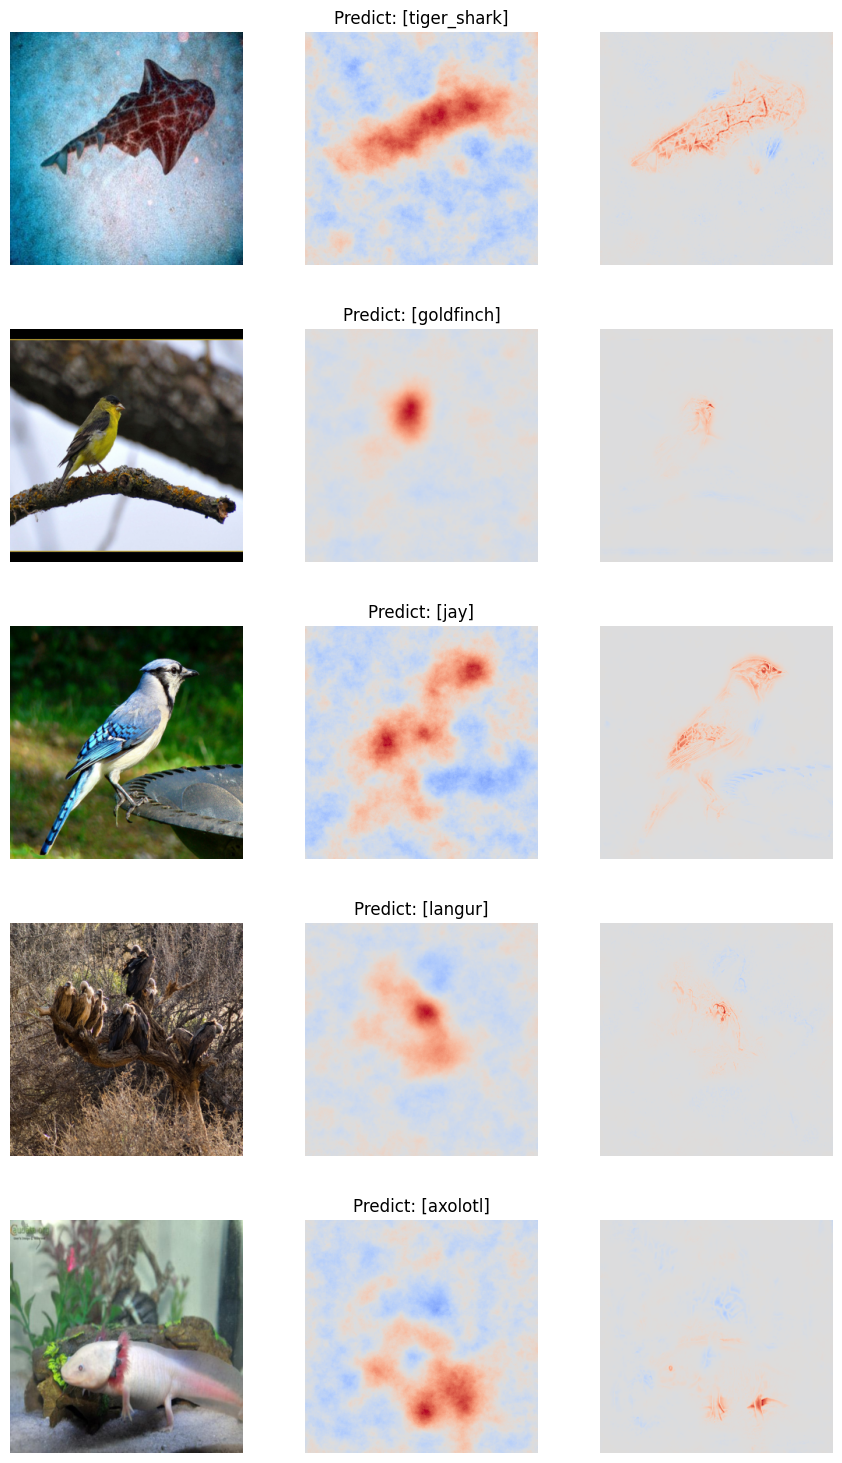

In [ ]:
# Sample explanations
target_idx = [20, 40, 60, 80, 100]
_, axs = plt.subplots(len(target_idx), 3, figsize=(9, 3*len(target_idx)))
num_per_row = axs.shape[-1]
axs = axs.flatten()
plt.tight_layout()
for ax in axs: ax.axis('off')

for i, idx in enumerate(target_idx):
    img_bchw = dataset[idx][0].unsqueeze(0)
    pred = m(img_bchw.cuda()).argmax()
    attr, enhanced = expl.explain(m, img_bchw, target_class=pred, verbose=True, visual_enhanced=True)
    ax_idx_shift = i*num_per_row
    show_img(axs[ax_idx_shift+0], img_bchw)
    show_attr(axs[ax_idx_shift+1], attr)
    show_attr(axs[ax_idx_shift+2], enhanced)
    axs[ax_idx_shift+1].set_title(f'Predict: [{IDX2NAME[pred]}]')


### Example of attribution for different class labels given one explicand

In [6]:
img_bchw = dataset[0][0].unsqueeze(0)
top5 = m(img_bchw.cuda()).detach().cpu().topk(5)
confidences, class_labels = top5.values.tolist()[0], top5.indices.tolist()[0]
for v, l in zip(confidences, class_labels):
    print(f'{IDX2NAME[l]}: [{v:.4f}]')

tench: [0.9348]
barracouta: [0.0020]
reel: [0.0010]
coho: [0.0007]
rifle: [0.0005]


 35%|███▌      | 28/79 [00:01<00:02, 18.87it/s]

100%|██████████| 79/79 [00:04<00:00, 19.05it/s]


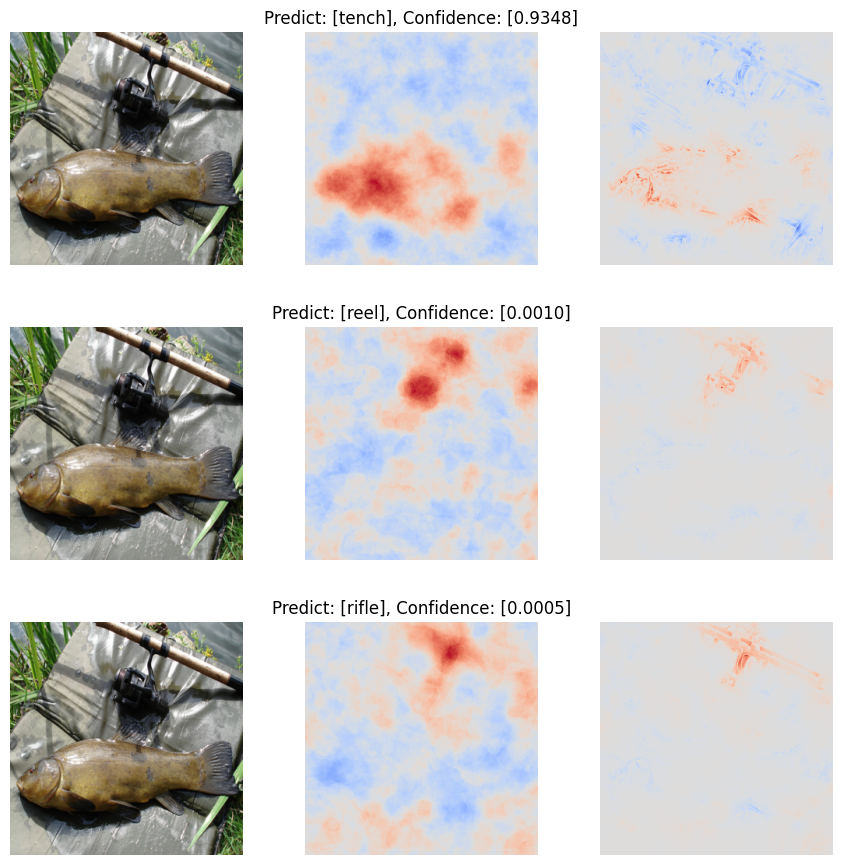

In [7]:
top_lbl_1_3_5 = [class_labels[i] for i in [0,2,4]]
conf_1_3_5 = [confidences[i] for i in [0,2,4]]
_, axs = plt.subplots(len(top_lbl_1_3_5), 3, figsize=(9, 3*len(top_lbl_1_3_5)))
num_per_row = axs.shape[-1]
axs = axs.flatten()
plt.tight_layout()
for ax in axs: ax.axis('off')

for i, lbl in enumerate(top_lbl_1_3_5):
    attr, enhanced = expl.explain(m, img_bchw, target_class=lbl, verbose=True, visual_enhanced=True)
    ax_idx_shift = i*num_per_row
    show_img(axs[ax_idx_shift+0], img_bchw)
    show_attr(axs[ax_idx_shift+1], attr)
    show_attr(axs[ax_idx_shift+2], enhanced)
    axs[ax_idx_shift+1].set_title(f'Predict: [{IDX2NAME[lbl]}], Confidence: [{conf_1_3_5[i]:.4f}]')
